# World Data League 2021
## Notebook Template

This notebook is one of the mandatory deliverables when you submit your solution (alongside the video pitch). Its structure follows the WDL evaluation criteria and it has dedicated cells where you can add descriptions. Make sure your code is readable as it will be the only technical support the jury will have to evaluate your work.

The notebook must:

*   💻 have all the code that you want the jury to evaluate
*   🧱 follow the predefined structure
*   📄 have markdown descriptions where you find necessary
*   👀 be saved with all the output that you want the jury to see
*   🏃‍♂️ be runnable


## External links and resources
Paste here all the links to external resources that are necessary to understand and run your code. Add descriptions to make it clear how to use them during evaluation.

https://github.com/hugonne/ds4a-encicla/blob/master/data/Estaciones_datos_metereologico.csv --> Used to get station locations to build the geographical dataframe 

## Introduction

### Firstly,
we tried to understand the data by portraying the main patterns in bike loans across weekdays and saturdays. This is the only way we could ever develop a solution an find valuable recommendations for EnCicla Medellín;

### Secondly,
and most importantly, we tried to the implement the basis of a decision-support software tool which would allow EnClicla staff to pick a weekdar and hour, and get a **list of stations that are prectided to need changes in bike supply, ranked by priority**, enabling them to transport bikes from and to where they are needed, maximizing efficiency.

### To do that,
we used the provided datasets and split it into tables with the starts and ends of loans, as well as a Geographical Dataframe, built through a dataset that corresponds stations to their locations, found in the link above.

## Development

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

### 1. Creating the needed dataframes

In [35]:
# Loans DF

loans_df = pd.read_csv('data/bike_loans.csv', sep=';',encoding='utf-8')
loans_df.columns = ['loan_id', 'user_id','bike_tag_id', 'time_start_loan', 'time_stop_loan', "station_loan_id", "origin_position", "station_returned_id", 'destined_position', "cost", "descr", "worker_name", "not_app"]
loans_df = loans_df.drop(['cost', 'descr', 'not_app'], axis = 1)

loans_df.head(5)

loan_id  user_id   bike_tag_id          time_start_loan  \
0  6501462    18701  000017B00743  2017-06-21 14:22:11.000   
1  6501318    41811  000017AFF83C  2017-06-21 14:07:18.000   
2  6501489    96620  000017AFFB6F  2017-06-21 14:25:11.000   
3  6501001    16055  0000182A3B7B  2017-06-21 13:35:52.000   
4  6501421     6431  000017AFE810  2017-06-21 14:17:56.000   

            time_stop_loan  station_loan_id  origin_position  \
0  2017-06-21 14:38:29.000                8                1   
1  2017-06-21 14:39:06.000               56                6   
2  2017-06-21 14:39:07.000               36               25   
3  2017-06-21 14:39:22.000                8                1   
4  2017-06-21 14:39:26.000               56               14   

   station_returned_id  destined_position   worker_name  
0                 43.0                1.0  jhon.castano  
1                 54.0                NaN       monitor  
2                  9.0               13.0           NaN  
3                  9.0                6.0           NaN  
4                 54.0                NaN       monitor

In [ ]:
# Start loan DF --> data on the start of each bike loan
# Stop Loan Df --> data on the end of each bike loan

# setting columns
start_loan_df = loans_df[['loan_id', 'user_id', 'time_start_loan', 'station_loan_id']]
stop_loan_df = loans_df[['loan_id', 'user_id', 'time_stop_loan', 'station_returned_id']]

# time to datetime format
start_loan_df['time_start_loan'] =  pd.to_datetime(start_loan_df['time_start_loan'])
stop_loan_df['time_stop_loan'] =  pd.to_datetime(stop_loan_df['time_stop_loan'])

# year
start_loan_df['year'] = start_loan_df['time_start_loan'].dt.year
stop_loan_df['year'] = stop_loan_df.time_stop_loan.dt.year

# month
start_loan_df['month'] = start_loan_df['time_start_loan'].dt.month
stop_loan_df['month'] = stop_loan_df.time_stop_loan.dt.month

# day
start_loan_df['day'] = start_loan_df['time_start_loan'].dt.day
stop_loan_df['day'] = stop_loan_df.time_stop_loan.dt.day

# hour
start_loan_df['hour'] = start_loan_df['time_start_loan'].dt.hour
stop_loan_df['hour'] = stop_loan_df.time_stop_loan.dt.hour

In [5]:
# Geo DF

# stations_df = pd.read_csv('https://raw.githubusercontent.com/hugonne/ds4a-encicla/master/data/Estaciones_datos_metereologico.csv', sep=';', encoding='utf-8')
stations_df = pd.read_csv('data/station_location_with_id.csv', sep=';', encoding='utf-8')

stations_df.Lat = stations_df['Lat'].apply(lambda x: x.replace(',','.'))
stations_df.Lat = pd.to_numeric(stations_df.Lat, downcast="float")

stations_df.Lon = stations_df['Lon'].apply(lambda x: x.replace(',','.'))
stations_df.Lon = pd.to_numeric(stations_df.Lon, downcast="float")

geo_df = gpd.GeoDataFrame(stations_df, geometry=gpd.points_from_xy(stations_df.Lon, stations_df.Lat))

geo_df['Center_point'] = geo_df['geometry'].centroid
# Extract lat and lon from the centerpoint
geo_df["Lat"] = geo_df.Center_point.map(lambda p: p.x)
geo_df["Lon"] = geo_df.Center_point.map(lambda p: p.y)

geo_df.crs = "EPSG:4326"
#geo_df = geo_df.to_crs(epsg=3857)

In [28]:
stations_df

ID             Description  numSlots shortName        Lat       Lon  \
0      1                 Moravia        15       MRV -75.564804  6.276585   
1      2             Universidad        33       UNI -75.565300  6.269267   
2      3                  Ruta N        40       RTN -75.566345  6.265182   
3      4              Punto Cero        10       PT0 -75.575066  6.265161   
4      5    Universidad Nacional        33       NaN -75.578812  6.259663   
..   ...                     ...       ...       ...        ...       ...   
102  138            Los Naranjos        36      PITA -75.606987  6.171916   
103  139             Villa Paula        40      PITA -75.606903  6.174198   
104  140       Parque el Artista        40      PITA -75.602173  6.178924   
105  141   Puente pan de Queso I        52      PITA -75.596443  6.175649   
106  142  Puente pan de Queso II        40      PITA -75.596619  6.175478   

     isManual                                     webDescription  \
0           1  Frente a la entrada principal del Centro de De...   
1           1  Bajo el viaducto de la estación Universidad de...   
2           0  Frente a la fachada principal de Ruta N sobre ...   
3           1  Intercambio vial de Punto Cero al lado de la e...   
4           1  Portería de la Iguaná con Carrera 65 de la Uni...   
..        ...                                                ...   
102         0                                                NaN   
103         0                                                NaN   
104         0                                                NaN   
105         0                                                NaN   
106         0                                                NaN   

                                                 photo  \
0    https://encicla.metropol.gov.co/imgstations/mo...   
1    https://encicla.metropol.gov.co/imgstations/un...   
2    https://encicla.metropol.gov.co/imgstations/ru...   
3    https://encicla.metropol.gov.co/imgstations/pu...   
4    https://encicla.metropol.gov.co/imgstations/un...   
..                                                 ...   
102                                                NaN   
103                                                NaN   
104                                                NaN   
105                                                NaN   
106                                                NaN   

                      geometry               Center_point  
0    POINT (-75.56480 6.27659)  POINT (-75.56480 6.27659)  
1    POINT (-75.56530 6.26927)  POINT (-75.56530 6.26927)  
2    POINT (-75.56635 6.26518)  POINT (-75.56635 6.26518)  
3    POINT (-75.57507 6.26516)  POINT (-75.57507 6.26516)  
4    POINT (-75.57881 6.25966)  POINT (-75.57881 6.25966)  
..                         ...                        ...  
102  POINT (-75.60699 6.17192)  POINT (-75.60699 6.17192)  
103  POINT (-75.60690 6.17420)  POINT (-75.60690 6.17420)  
104  POINT (-75.60217 6.17892)  POINT (-75.60217 6.17892)  
105  POINT (-75.59644 6.17565)  POINT (-75.59644 6.17565)  
106  POINT (-75.59662 6.17548)  POINT (-75.59662 6.17548)  

[107 rows x 11 columns]

### 2. Exploratory Data Analysis

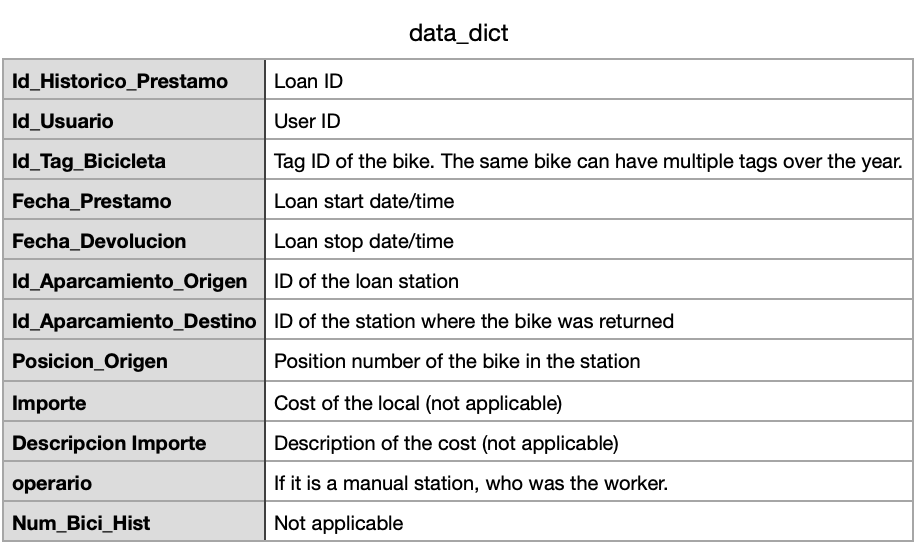

In [2]:
loans_df = pd.read_csv('data/bike_loans.csv', sep=';',encoding='utf-8')

In [3]:
loans_df.columns = ['loan_id', 'user_id','bike_tag_id', 'time_start_loan', 'time_stop_loan', "station_loan_id", "origin_position", "station_returned_id", 'destined_position', "cost", "descr", "worker_name", "not_app"]


In [4]:
loans_df = loans_df.drop(['cost', 'descr', 'not_app'], axis = 1)

In [5]:
loans_df

loan_id  user_id   bike_tag_id          time_start_loan  \
0          6501462    18701  000017B00743  2017-06-21 14:22:11.000   
1          6501318    41811  000017AFF83C  2017-06-21 14:07:18.000   
2          6501489    96620  000017AFFB6F  2017-06-21 14:25:11.000   
3          6501001    16055  0000182A3B7B  2017-06-21 13:35:52.000   
4          6501421     6431  000017AFE810  2017-06-21 14:17:56.000   
...            ...      ...           ...                      ...   
14225350  17272860    26650  00001B7DE4E2  2021-04-20 18:46:57.000   
14225351  17272686   151968  000030778CC7  2021-04-20 18:28:09.000   
14225352  17272992   155196  000037FDF432  2021-04-20 18:59:53.000   
14225353  17272844   144508  000026B3E61C  2021-04-20 18:45:42.000   
14225354  17272787   120899  0000B5C6F1E2  2021-04-20 18:39:06.000   

                   time_stop_loan  station_loan_id  origin_position  \
0         2017-06-21 14:38:29.000                8                1   
1         2017-06-21 14:39:06.000               56                6   
2         2017-06-21 14:39:07.000               36               25   
3         2017-06-21 14:39:22.000                8                1   
4         2017-06-21 14:39:26.000               56               14   
...                           ...              ...              ...   
14225350  2021-04-20 19:07:25.000               45               18   
14225351  2021-04-20 19:08:00.000               96               20   
14225352  2021-04-20 19:08:59.000               56               37   
14225353  2021-04-20 19:13:45.000               61                1   
14225354  2021-04-20 19:51:17.000                8                1   

          station_returned_id  destined_position     worker_name  
0                        43.0                1.0    jhon.castano  
1                        54.0                NaN         monitor  
2                         9.0               13.0             NaN  
3                         9.0                6.0             NaN  
4                        54.0                NaN         monitor  
...                       ...                ...             ...  
14225350                 89.0               11.0             NaN  
14225351                 96.0               15.0             NaN  
14225352                 89.0               15.0             NaN  
14225353                  1.0                1.0  johan.granados  
14225354                  2.0                1.0  beatriz.osorio  

[14225355 rows x 10 columns]

In [6]:
# Converting date & time columns to datetime format

loans_df['time_start_loan'] = pd.to_datetime(loans_df['time_start_loan'])
loans_df['time_stop_loan'] = pd.to_datetime(loans_df['time_stop_loan'])

In [7]:
#Creating year, month, and weekday columns

loans_df['year'] = loans_df['time_start_loan'].dt.year
loans_df['month'] = loans_df['time_start_loan'].dt.month
loans_df['weekday'] = loans_df['time_start_loan'].dt.weekday
loans_df['hour'] = loans_df['time_start_loan'].dt.hour

print(f"We have data for the following years:\n{np.sort(loans_df['year'].unique())}")

We have data for the following years:
[2014 2015 2016 2017 2018 2019 2020 2021]


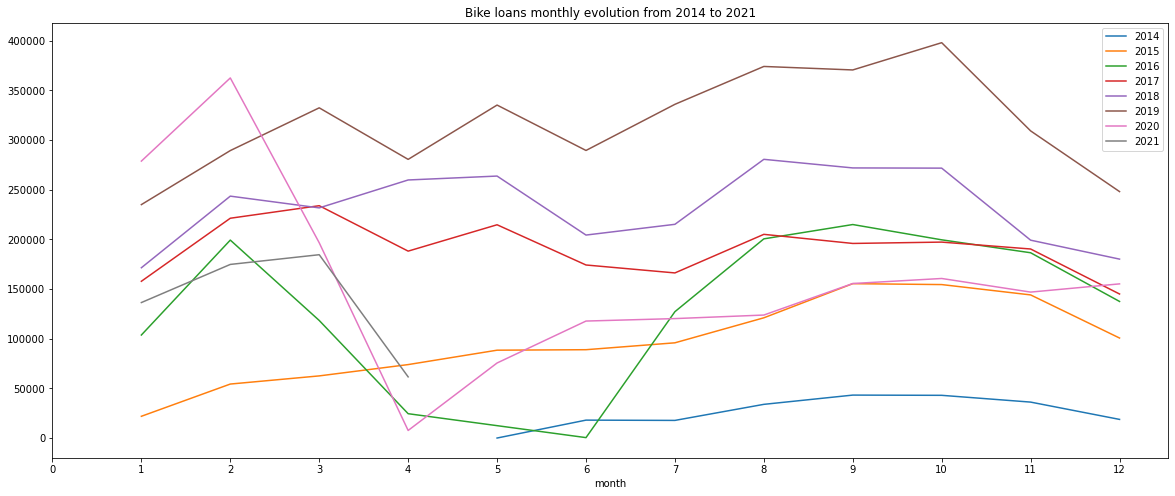

In [8]:
#Seeing yearly evolution and monthly patterns

count_df = loans_df.groupby(['year','month']).count()[['loan_id']].rename(columns={'loan_id':'nr_trips'}).reset_index()

fig, axes = plt.subplots()

for year in np.sort(loans_df['year'].unique()):
    count_df[count_df['year']==year].plot(x= 'month', y='nr_trips',
                                          ax = axes,
                                          figsize = (20, 8),
                                          xticks = range(0,13)
                                         )

plt.title('Bike loans monthly evolution from 2014 to 2021')
plt.legend(np.sort(loans_df['year'].unique()))
plt.show()

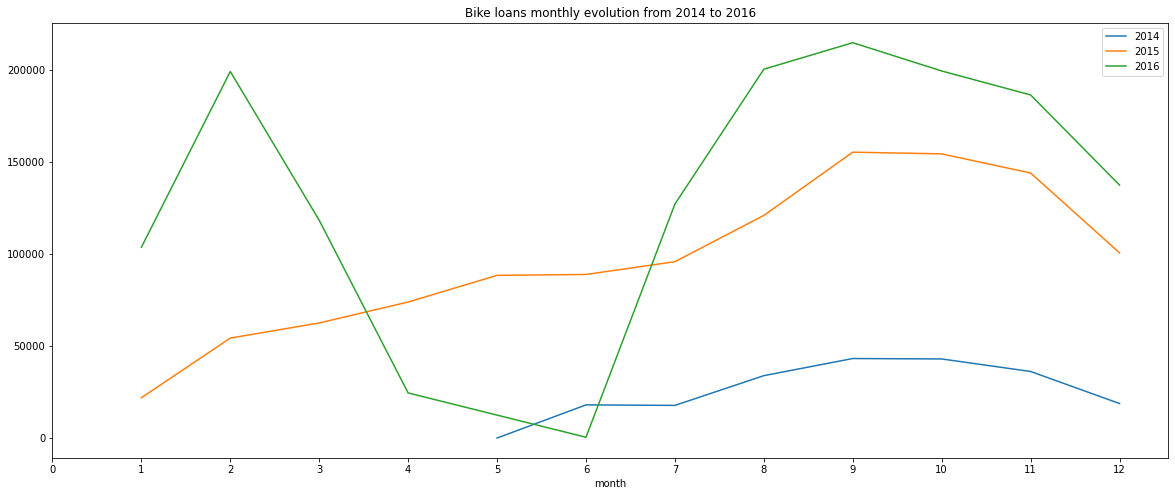

In [9]:
fig, axes = plt.subplots()

for year in range(2014,2017):
    count_df[count_df['year']==year].plot(x= 'month', y='nr_trips',
                                          ax = axes,
                                          figsize = (20, 8),
                                          xticks = range(0,13)
                                         )

plt.title('Bike loans monthly evolution from 2014 to 2016')
plt.legend(range(2014,2017))
plt.show()

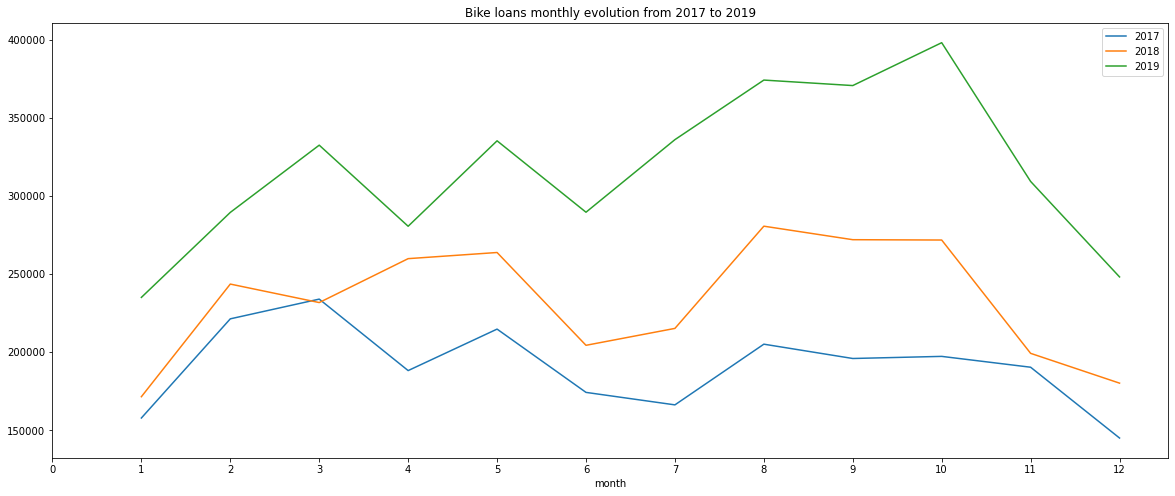

In [10]:
fig, axes = plt.subplots()

for year in range(2017,2020):
    count_df[count_df['year']==year].plot(x= 'month', y='nr_trips',
                                          ax = axes,
                                          figsize = (20, 8),
                                          xticks = range(0,13)
                                         )

plt.title('Bike loans monthly evolution from 2017 to 2019')
plt.legend(range(2017,2020))
plt.show()

In [11]:
loans_df = loans_df[(loans_df['year']>=2017)&(loans_df['year']<=2019)]

loans_df.shape[0]

8881499

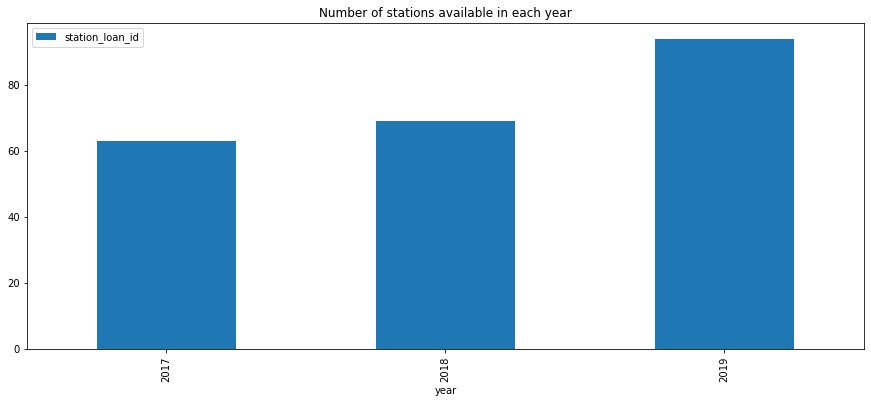

In [12]:
loans_df[['year','station_loan_id']].drop_duplicates().groupby('year').count().plot(y='station_loan_id', use_index = True, 
                                                                                    figsize = (15, 6),
                                                                                    kind='bar')
plt.title('Number of stations available in each year')
plt.show()

In [14]:
loans_df.head()

loan_id  user_id   bike_tag_id     time_start_loan      time_stop_loan  \
0  6501462    18701  000017B00743 2017-06-21 14:22:11 2017-06-21 14:38:29   
1  6501318    41811  000017AFF83C 2017-06-21 14:07:18 2017-06-21 14:39:06   
2  6501489    96620  000017AFFB6F 2017-06-21 14:25:11 2017-06-21 14:39:07   
3  6501001    16055  0000182A3B7B 2017-06-21 13:35:52 2017-06-21 14:39:22   
4  6501421     6431  000017AFE810 2017-06-21 14:17:56 2017-06-21 14:39:26   

   station_loan_id  origin_position  station_returned_id  destined_position  \
0                8                1                 43.0                1.0   
1               56                6                 54.0                NaN   
2               36               25                  9.0               13.0   
3                8                1                  9.0                6.0   
4               56               14                 54.0                NaN   

    worker_name  year  month  weekday  hour  
0  jhon.castano  2017      6        2    14  
1       monitor  2017      6        2    14  
2           NaN  2017      6        2    14  
3           NaN  2017      6        2    13  
4       monitor  2017      6        2    14

In [15]:
loans_df['trip_duration'] = np.round((loans_df['time_stop_loan']-loans_df['time_start_loan'])/np.timedelta64(1, 'm'),2)

In [16]:
outliers_df = loans_df[(loans_df['trip_duration'] <= 1) | (loans_df['trip_duration'] >= 90)]

print(f"% of trips below 1 minute or over 1.5 hours: {np.round(outliers_df.shape[0]/loans_df.shape[0],4)*100}")

% of trips below 1 minute or over 1.5 hours: 4.569999999999999


#### Since trips below 1 minute or over 1.5 hours, theoretically, don't represent actual trips but rather mistakes when recording the data or similar and accounting for it's weight in the dataset, the team considers them outliers.

In [17]:
#Removing the outliers

loans_df = loans_df[~loans_df.index.isin(outliers_df.index)]

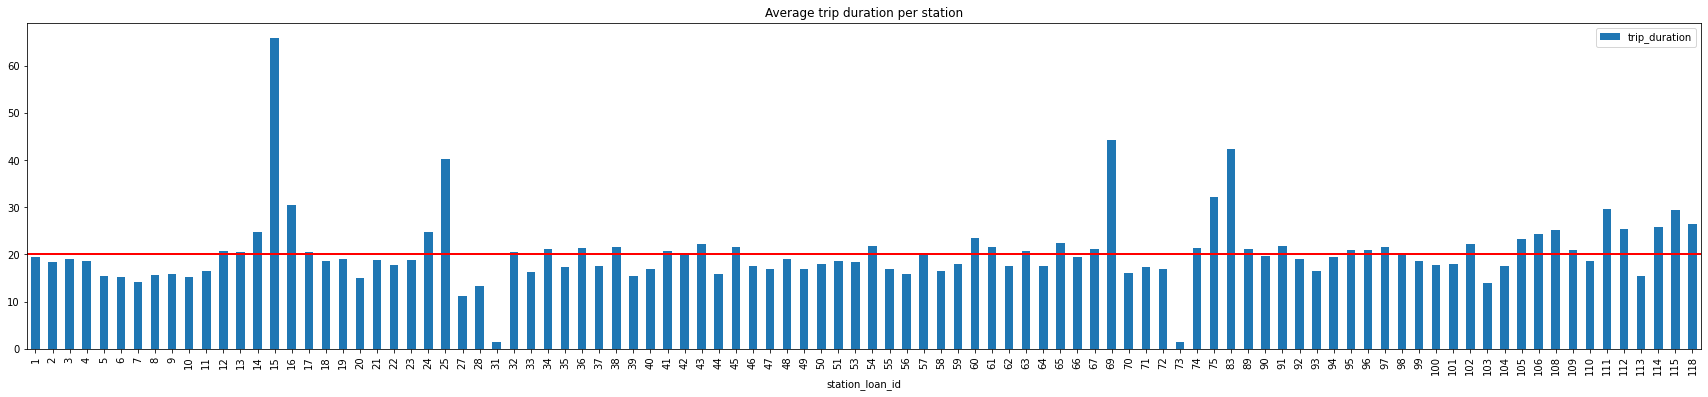

In [18]:
#Plotting the average duration of trip per station along with the average total trip duration

loans_df.groupby(['station_loan_id']).mean()[['trip_duration']].plot(kind='bar',
                                                                     figsize = (30, 6))

mean_duration = np.average(loans_df.groupby(['station_loan_id']).mean()['trip_duration'])

plt.title('Average trip duration per station')
plt.axhline(y=20, xmin=0, xmax=151,
            linewidth=2, color='r')
plt.show()

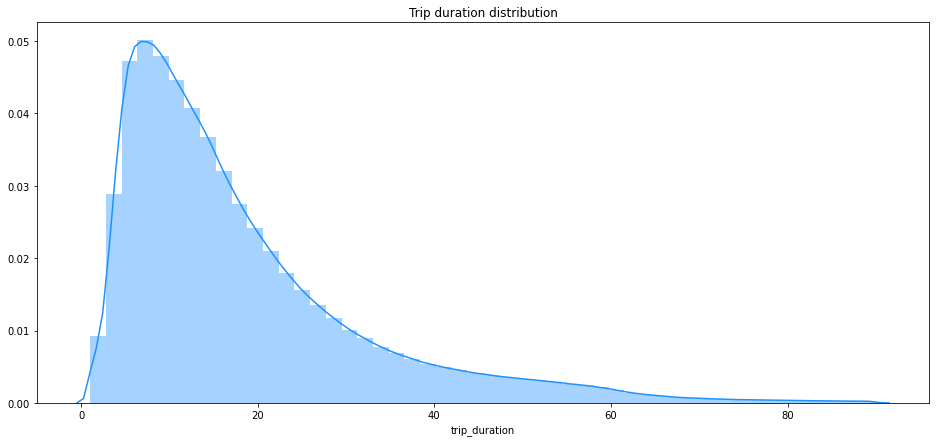

In [19]:

plt.figure(figsize=(16,7))
sns.distplot(loans_df['trip_duration'], color="dodgerblue", label="Compact")
plt.title('Trip duration distribution')
plt.show()


#### At what time of the day do we need more bikes? And the least?

##### Weekday Analysis

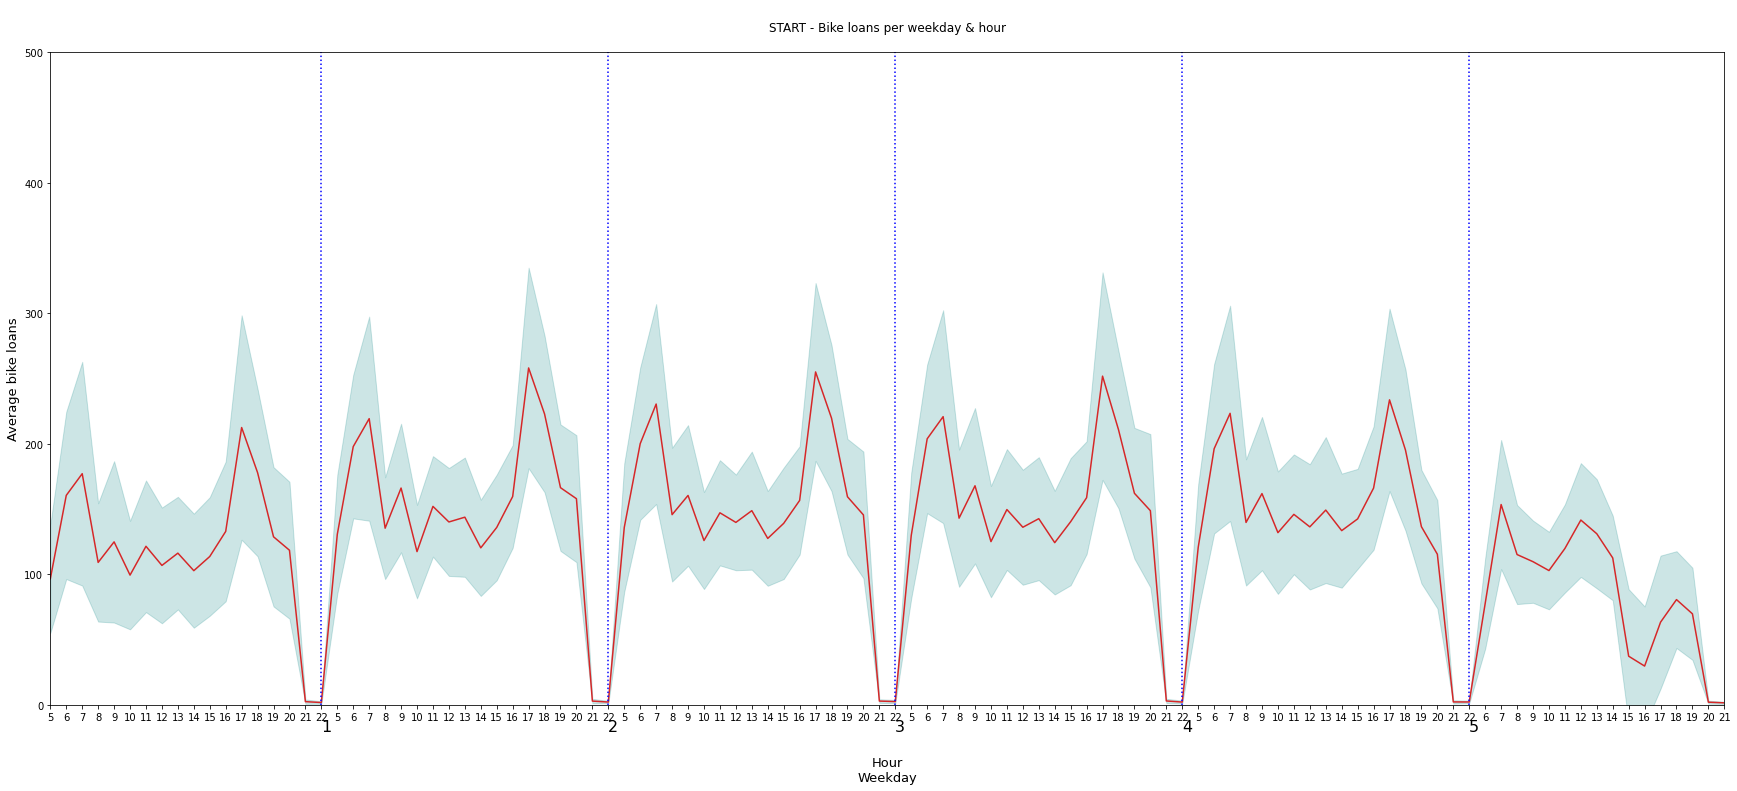

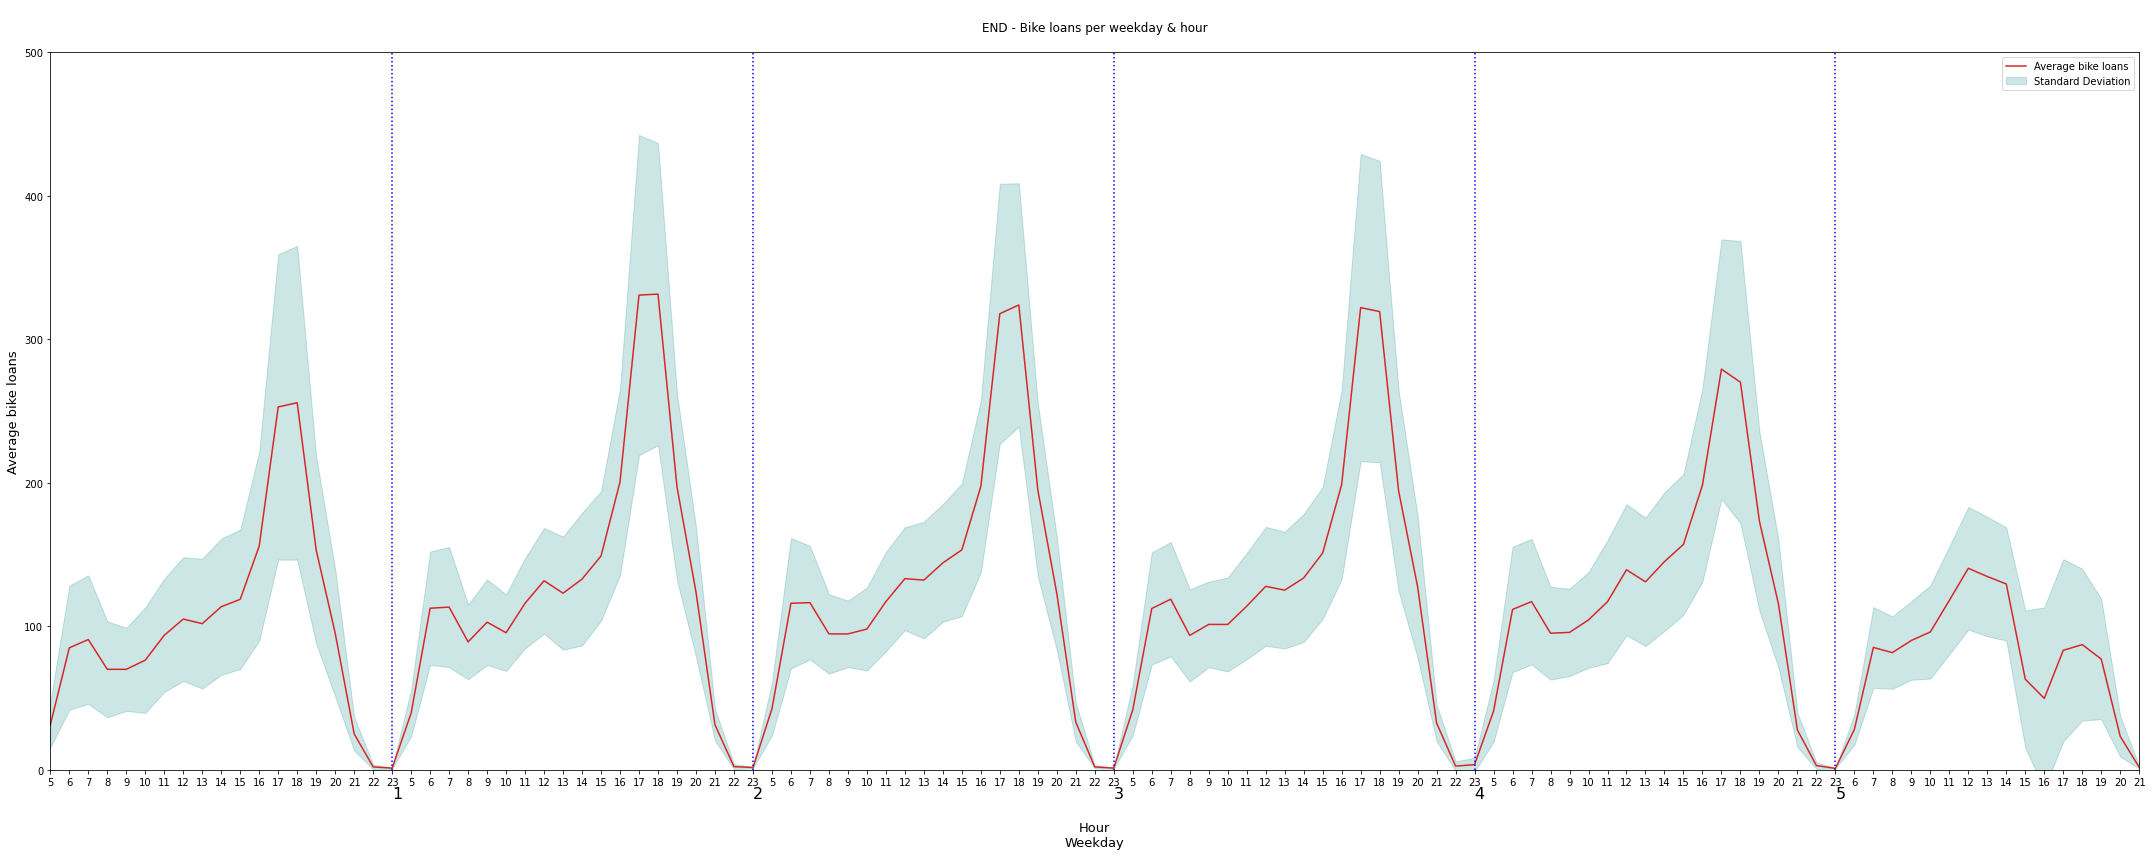

In [15]:
metrics_df = start_metrics_df
fig, ax = plt.subplots(figsize=(30,12))


ax.fill_between(metrics_df.index,
metrics_df['mean']-metrics_df['std'],
metrics_df['mean']+metrics_df['std'],
color= 'teal', alpha=0.2, label = 'Standard Deviation')

metrics_df['mean'].plot(ax=ax, c='C3', label= 'Average bike loans')

ax.set_ylabel("Average bike loans", fontsize = 13)
ax.set_xlabel("\n\nHour\nWeekday", fontsize = 13)
ax.set_xticks(list(metrics_df.index))
ax.set_xticklabels(metrics_df['hour'])
for row in range(metrics_df.index[0], metrics_df.index[-1]):
    if metrics_df['weekday'][row] != metrics_df['weekday'][row+1]:
        plt.axvline(x=row, ls=':', c='b', label = '_nolegend_')
        plt.text(row, metrics_df['mean'][row], metrics_df['weekday'][row+1],
                horizontalalignment='left',
                fontsize = 16,
                position=(row,-20))

plt.ylim((0, 500))
plt.xlim((metrics_df.index[0], metrics_df.index[-1]))
plt.title("\nSTART - Bike loans per weekday & hour\n"
          )


metrics_df = end_metrics_df
fig, ax = plt.subplots(figsize=(30,12))


ax.fill_between(metrics_df.index,
metrics_df['mean']-metrics_df['std'],
metrics_df['mean']+metrics_df['std'],
color= 'teal', alpha=0.2, label = 'Standard Deviation')

metrics_df['mean'].plot(ax=ax, c='C3', label= 'Average bike loans')

ax.set_ylabel("Average bike loans", fontsize = 13)
ax.set_xlabel("\n\nHour\nWeekday", fontsize = 13)
ax.set_xticks(list(metrics_df.index))
ax.set_xticklabels(metrics_df['hour'])
for row in range(metrics_df.index[0], metrics_df.index[-1]):
    if metrics_df['weekday'][row] != metrics_df['weekday'][row+1]:
        plt.axvline(x=row, ls=':', c='b', label = '_nolegend_')
        plt.text(row, metrics_df['mean'][row], metrics_df['weekday'][row+1],
                horizontalalignment='left',
                fontsize = 16,
                position=(row,-20))

plt.ylim((0, 500))
plt.xlim((metrics_df.index[0], metrics_df.index[-1]))
plt.title("\nEND - Bike loans per weekday & hour\n"
          )
plt.tight_layout()
plt.legend()
plt.show()

#### Number of trips per month

In [23]:
loans_df.groupby('month').count()['loan_id']

month
1     533919
2     722727
3     760626
4     698433
5     777383
6     639161
7     686876
8     824264
9     805108
10    832147
11    664281
12    531067
Name: loan_id, dtype: int64

In [7]:
geo_df['Center_point'] = geo_df['geometry'].centroid
# Extract lat and lon from the centerpoint
geo_df["Lat"] = geo_df.Center_point.map(lambda p: p.x)
geo_df["Lon"] = geo_df.Center_point.map(lambda p: p.y)

geo_df.crs = "EPSG:4326"
geo_df = geo_df.to_crs(epsg=3857)

<ipython-input-7-9dfec3123ec2>:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geo_df['Center_point'] = geo_df['geometry'].centroid


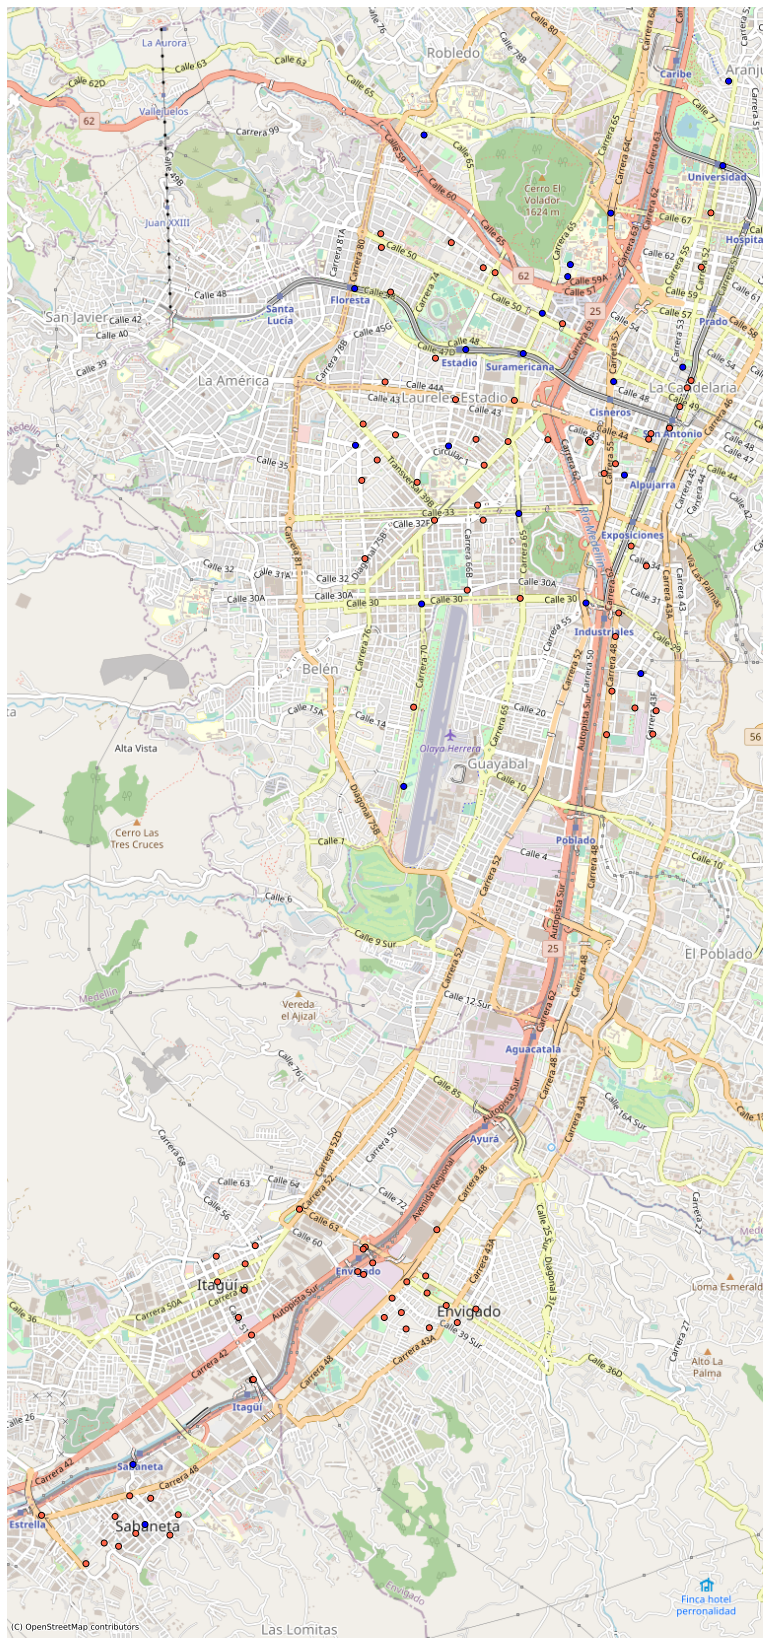

In [31]:
point_color = (geo_df['isManual'] > 0).map({True: 'blue', False: 'tomato'})

ax = geo_df.plot(figsize=(20, 30), color = point_color, alpha = 1, edgecolor = 'k')

ctx.add_basemap(ax, source = ctx.providers.OpenStreetMap.Mapnik, zoom = 14)
ax.set_axis_off()


All Envigado stations are automatic, and so are most of Sabaneta's. Manual stations (represented by the blue dots) are mostly located in the Northern part of the Aburrá Valley.

In [34]:
print(f"Manual stations represent {np.round((geo_df[geo_df['isManual']==1].shape[0]/geo_df.shape[0])*100,2)}% of all stations.")

Manual stations represent 20.56% of all stations.


### 3. Creating a more complex dataframes to predict demand

In [18]:
start_metrics_df_original = start_metrics_df_original.merge(geo_df[['ID','numSlots']], right_on="ID", left_on="station_loan_id")

del start_metrics_df_original['ID']
del start_metrics_df_original['std']

start_metrics_df_original

station_loan_id  weekday  hour        mean  numSlots
0                   1        0     5   58.333333       500
1                   1        0     6  107.666667       500
2                   1        0     7   82.555556       500
3                   1        0     8   60.361111       500
4                   1        0     9   73.833333       500
...               ...      ...   ...         ...       ...
8035              118        5    15    5.000000        40
8036              118        5    16    3.000000        40
8037              118        5    17    4.000000        40
8038              118        5    18    1.000000        40
8039              118        5    19    1.000000        40

[8040 rows x 5 columns]

In [69]:
end_metrics_df_original = end_metrics_df_original.merge(geo_df[['ID','numSlots']], right_on="ID", left_on="station_returned_id")
end_metrics_df_original = end_metrics_df_original.merge(geo_df[['ID', 'isManual']], right_on="ID", left_on="station_returned_id")

del end_metrics_df_original['ID_x']
del end_metrics_df_original['ID_y']
del end_metrics_df_original['std']

end_metrics_df_original

station_returned_id  weekday  hour       mean  numSlots  isManual
0                     1.0        0     5   4.687500        15         1
1                     1.0        0     6  20.250000        15         1
2                     1.0        0     7  16.194444        15         1
3                     1.0        0     8  22.361111        15         1
4                     1.0        0     9  29.972222        15         1
...                   ...      ...   ...        ...       ...       ...
9086                118.0        5    16   2.000000        40         0
9087                118.0        5    17   2.000000        40         0
9088                118.0        5    18   1.500000        40         0
9089                118.0        5    19   2.000000        40         0
9090                118.0        5    20   1.000000        40         0

[9091 rows x 6 columns]

In [24]:
full_df = end_metrics_df_original.merge(start_metrics_df_original, right_on=['station_loan_id',"weekday","hour"], left_on=['station_returned_id',"weekday","hour"])
full_df = full_df.rename(columns={'mean_x':'bikes_returned', "mean_y": "bikes_taken", "numSlots_x": "total_slots"})
del full_df['numSlots_y']
del full_df['station_loan_id']
full_df

station_returned_id  weekday  hour  bikes_returned  total_slots  \
0                     1.0        0     5        4.687500           15   
1                     1.0        0     6       20.250000           15   
2                     1.0        0     7       16.194444           15   
3                     1.0        0     8       22.361111           15   
4                     1.0        0     9       29.972222           15   
...                   ...      ...   ...             ...          ...   
7870                118.0        5    15        3.000000           40   
7871                118.0        5    16        2.000000           40   
7872                118.0        5    17        2.000000           40   
7873                118.0        5    18        1.500000           40   
7874                118.0        5    19        2.000000           40   

      bikes_taken  
0       58.333333  
1      107.666667  
2       82.555556  
3       60.361111  
4       73.833333  
...           ...  
7870     5.000000  
7871     3.000000  
7872     4.000000  
7873     1.000000  
7874     1.000000  

[7875 rows x 6 columns]

In [77]:
# avb_bikes -> predicted available bikes

full_df.loc[0, 'avb_bikes'] = full_df.loc[0, 'total_slots'] - full_df.loc[0, 'bikes_taken'] + full_df.loc[0, 'bikes_returned']
full_df

station_returned_id  weekday  hour  bikes_returned  total_slots  \
0                     1.0        0     5        4.687500           15   
1                     1.0        0     6       20.250000           15   
2                     1.0        0     7       16.194444           15   
3                     1.0        0     8       22.361111           15   
4                     1.0        0     9       29.972222           15   
...                   ...      ...   ...             ...          ...   
7870                118.0        5    15        3.000000           40   
7871                118.0        5    16        2.000000           40   
7872                118.0        5    17        2.000000           40   
7873                118.0        5    18        1.500000           40   
7874                118.0        5    19        2.000000           40   

      bikes_taken  avb_bikes  
0       58.333333 -38.645833  
1      107.666667        NaN  
2       82.555556        NaN  
3       60.361111        NaN  
4       73.833333        NaN  
...           ...        ...  
7870     5.000000        NaN  
7871     3.000000        NaN  
7872     4.000000        NaN  
7873     1.000000        NaN  
7874     1.000000        NaN  

[7875 rows x 7 columns]

In [78]:
station = 4.0
weekday = 10

for i in range(0, len(full_df)):
    
    if i == 0:
        #if full_df.loc[i, 'weekday'] != weekday:
        full_df.loc[i, 'avb_bikes'] = full_df.loc[i, 'total_slots'] - full_df.loc[i, 'bikes_taken'] + full_df.loc[i, 'bikes_returned']
        station = 1.0
        weekday = full_df.loc[i, 'weekday']
    
    elif full_df.loc[i, 'station_returned_id'] != station:
        #if full_df.loc[i, 'weekday'] != weekday:
        weekday = full_df.loc[i, 'weekday']
        full_df.loc[i, 'avb_bikes'] = full_df.loc[i, 'total_slots'] - full_df.loc[i, 'bikes_taken'] + full_df.loc[i, 'bikes_returned']
        station = i
            #weekday = full_df.loc[i, 'weekday']
            
    elif full_df.loc[i, 'weekday'] != weekday:
        full_df.loc[i, 'avb_bikes'] = full_df.loc[i, 'total_slots'] - full_df.loc[i, 'bikes_taken'] + full_df.loc[i, 'bikes_returned']
        #num = i
        weekday = full_df.loc[i, 'weekday']
            
    else:
    # creating available slots column
        full_df.loc[i, 'avb_bikes'] = full_df.loc[i-1, 'avb_bikes'] - full_df.loc[i, 'bikes_taken'] + full_df.loc[i, 'bikes_returned']

In [79]:
full_df

station_returned_id  weekday  hour  bikes_returned  total_slots  \
0                     1.0        0     5        4.687500           15   
1                     1.0        0     6       20.250000           15   
2                     1.0        0     7       16.194444           15   
3                     1.0        0     8       22.361111           15   
4                     1.0        0     9       29.972222           15   
...                   ...      ...   ...             ...          ...   
7870                118.0        5    15        3.000000           40   
7871                118.0        5    16        2.000000           40   
7872                118.0        5    17        2.000000           40   
7873                118.0        5    18        1.500000           40   
7874                118.0        5    19        2.000000           40   

      bikes_taken   avb_bikes  
0       58.333333  -38.645833  
1      107.666667 -126.062500  
2       82.555556 -192.423611  
3       60.361111 -230.423611  
4       73.833333 -274.284722  
...           ...         ...  
7870     5.000000   38.000000  
7871     3.000000   39.000000  
7872     4.000000   38.000000  
7873     1.000000   40.500000  
7874     1.000000   41.000000  

[7875 rows x 7 columns]

In [80]:
full_df['%capacity'] = full_df['avb_bikes']/full_df['total_slots']*100
full_df = round(full_df)
full_df

station_returned_id  weekday  hour  bikes_returned  total_slots  \
0                     1.0        0     5             5.0           15   
1                     1.0        0     6            20.0           15   
2                     1.0        0     7            16.0           15   
3                     1.0        0     8            22.0           15   
4                     1.0        0     9            30.0           15   
...                   ...      ...   ...             ...          ...   
7870                118.0        5    15             3.0           40   
7871                118.0        5    16             2.0           40   
7872                118.0        5    17             2.0           40   
7873                118.0        5    18             2.0           40   
7874                118.0        5    19             2.0           40   

      bikes_taken  avb_bikes  %capacity  
0            58.0      -39.0     -258.0  
1           108.0     -126.0     -840.0  
2            83.0     -192.0    -1283.0  
3            60.0     -230.0    -1536.0  
4            74.0     -274.0    -1829.0  
...           ...        ...        ...  
7870          5.0       38.0       95.0  
7871          3.0       39.0       98.0  
7872          4.0       38.0       95.0  
7873          1.0       40.0      101.0  
7874          1.0       41.0      102.0  

[7875 rows x 8 columns]

In [82]:
for i in range(0, len(full_df)):
    if full_df.loc[i, '%capacity'] > 90.0:
        full_df.loc[i, 'rebalance'] = "LOW"
    elif full_df.loc[i, '%capacity'] < 30.0:
        full_df.loc[i, 'rebalance'] = "HIGH"
    else:
        full_df.loc[i, 'rebalance'] = "NEUTRAL"

In [87]:
full_df = full_df.merge(end_metrics_df_original[['station_returned_id', 'isManual']], on='station_returned_id')

In [89]:
full_df.head(10)

station_returned_id  weekday  hour  bikes_returned  total_slots  \
0                  1.0        0     5             5.0           15   
1                  1.0        0     5             5.0           15   
2                  1.0        0     5             5.0           15   
3                  1.0        0     5             5.0           15   
4                  1.0        0     5             5.0           15   
5                  1.0        0     5             5.0           15   
6                  1.0        0     5             5.0           15   
7                  1.0        0     5             5.0           15   
8                  1.0        0     5             5.0           15   
9                  1.0        0     5             5.0           15   

   bikes_taken  avb_bikes  %capacity rebalance  isManual  
0         58.0      -39.0     -258.0      HIGH         1  
1         58.0      -39.0     -258.0      HIGH         1  
2         58.0      -39.0     -258.0      HIGH         1  
3         58.0      -39.0     -258.0      HIGH         1  
4         58.0      -39.0     -258.0      HIGH         1  
5         58.0      -39.0     -258.0      HIGH         1  
6         58.0      -39.0     -258.0      HIGH         1  
7         58.0      -39.0     -258.0      HIGH         1  
8         58.0      -39.0     -258.0      HIGH         1  
9         58.0      -39.0     -258.0      HIGH         1

### About full_df:

- Shows the amount of bikes expected to be at each location, **assuming a bike reposition every night, up until the number of slots available**;
- Shows the percentage of slots taken of each station (%capacity);
- Shows the rebalancing needs - HIGH means bikes are needed in that station, LOW means free spaces are needed.

### 4. Predicting demand for decision-making

Here, a function is used to return the stations needing intervention the most, as described above.

#### Parameters:
- weekday --> monday (0) through saturday (5)
- hour

In [13]:
def stations_to_act(weekday, hour):
    
    df = full_df[(full_df['weekday'] == weekday) & (full_df['hour'] == hour)]

    more_bikes = list(df.sort_values('%capacity').head(5)['station_returned_id'])

    less_bikes = list(df.sort_values('%capacity').tail(5)['station_returned_id'])

    stations_ids = more_bikes + less_bikes

    ax = geo_df[geo_df.ID.isin(stations_ids)].plot(figsize=(20, 30), color = 'tomato', alpha = 1)
    ctx.add_basemap(ax, source = ctx.providers.OpenStreetMap.Mapnik)
    ax.set_axis_off()

In [2]:
full_df = pd.read_csv('fullf_df.csv')
full_df.head(5)

station_returned_id  weekday  hour  bikes_returned  total_slots  \
0                  1.0        0     5             5.0          500   
1                  1.0        0     6            20.0          500   
2                  1.0        0     7            16.0          500   
3                  1.0        0     8            22.0          500   
4                  1.0        0     9            30.0          500   

   bikes_taken  avb_bikes  %capacity rebalance  
0         58.0      446.0       89.0   NEUTRAL  
1        108.0      359.0       72.0   NEUTRAL  
2         83.0      293.0       59.0   NEUTRAL  
3         60.0      255.0       51.0   NEUTRAL  
4         74.0      211.0       42.0   NEUTRAL

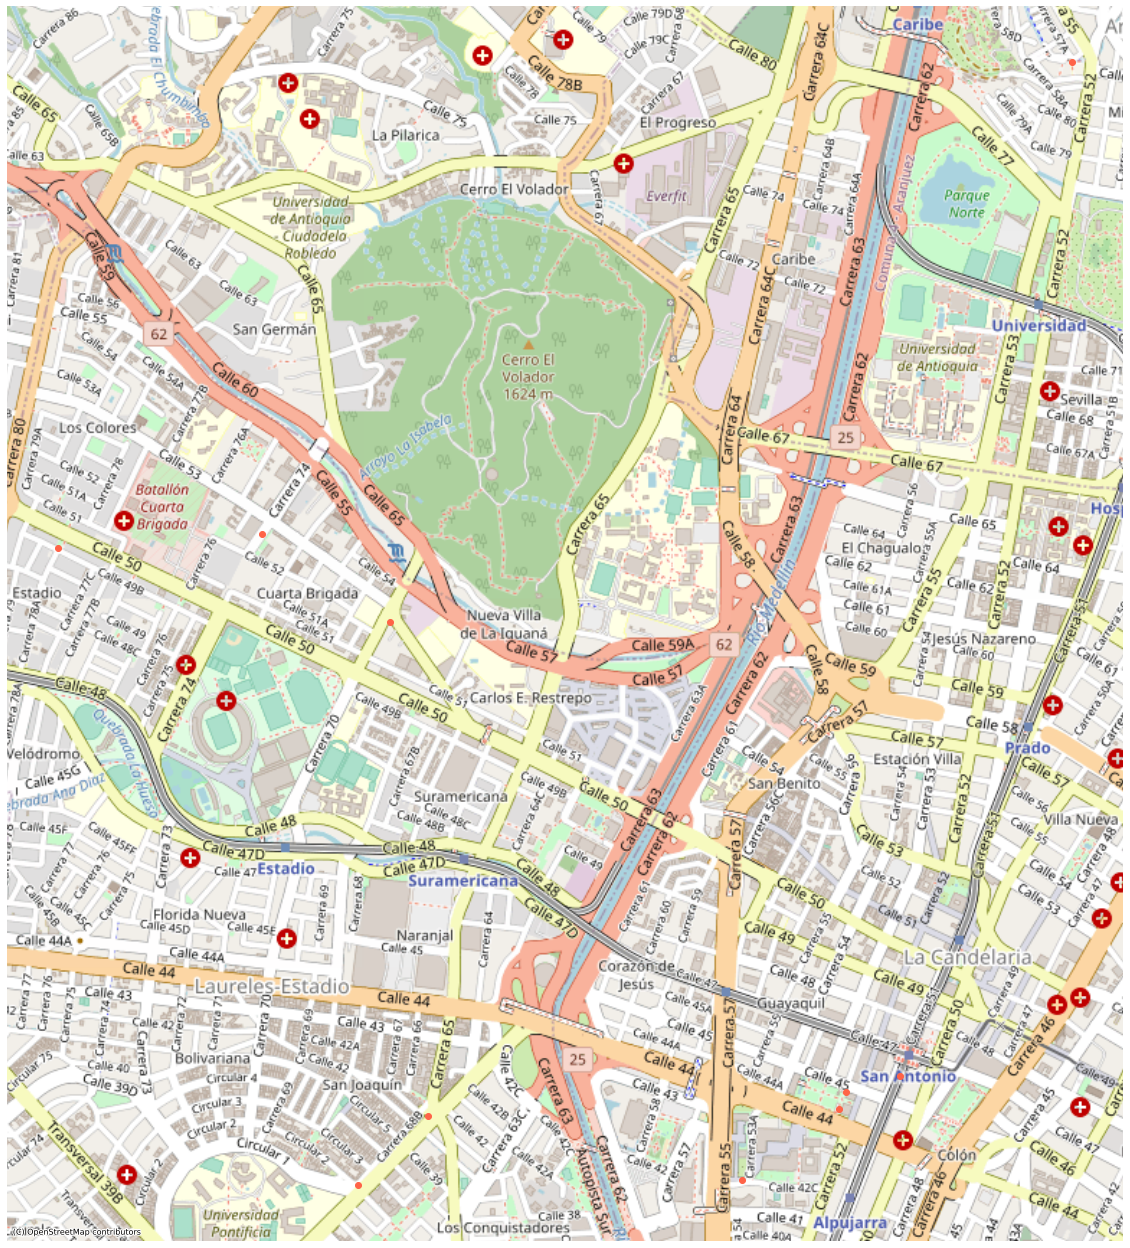

In [14]:
stations_to_act(3, 9)

## Conclusions

### Scalability and Impact

**Main:**

- The objective is that EnClicla staff can run the function **stations_to_act** with the desired parameters and check what stations need action.


**Also:**
- Although manual stations have no theoritical limit, we are not considering their capacity infinite. To us, it makes sense that they have quite some flexibility, but not that they could take infinite bikes;

- The full_df must be refined and corrected. Once a good enough dataframe is obtained, an optimization algorithm must be used to distribute bikes per stations in the optimal way: stations that need the most bikes most get them from stations that need the most spaces available, and the opposite as well, in that order of priority;

- The potential of a refined version of this solution is the maximization of efficiency when it comes to resource allocation (bikes). This solution should be used in symbiosis with a route-optimization system in order to minimize expenses and pollution when transporting bikes;

- Given the future needs of bycicle transportation arising from the usage of such solution, EnClicla must consider acquiring electric vehicles to do this distribution, seizing Colombian and International financial incentives to do so;

- In the future, as this process becomes standard, and so that EnCicla staff do not need to do the bycicle transportation on their own, a system of incentives could be implemented so that travelling from stations that - according to the model - **will need free docks** to stations that - according to the model - **will need bycicles** (in the short period of time that follows, like 1h/30min) becomes advantageous for the user. Examples of these incentives are free trips and rewards with private partners/government services.

### Future Work

- EnCicla should implement a feature that allows users to register bike and slot unavailability (with location and/or picture validation), which would feed the data model and contribute to the accuracy of the percentage capacity predictions;